In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.DeepGenerator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *

In [2]:
# Training Folder
path = r"..\data\pretuning"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"Pretuning - {timestamp}"

save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\yolo_tensors'
hl_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\hl_tensors'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy(features=4).to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy(features=5).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(data_path)
expert_buffer.clear(p=95)               # Reduce ratio of non-attack data by 90%. now ~equal
# 70 ist hier zu wenig. Mehr auf hand-labeled trainieren
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  3185
Storage of Prey Expert Buffer:  77648 



In [5]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=256, prey_bs=512, epochs=10, lr=1e-3, device='cpu'):
    # 1) Sample a large batch for BC
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    # 2) Split state and action
    if role == 'predator':
        states  = batch[..., :4]            # dx, dy, vx, vy
        actions = batch[:, 0, 4].squeeze()  # theta @ index 4
    else:
        states  = batch[..., :5]            # flag, dx, dy, vx, vy   <-- flag drin!
        actions = batch[:, 0, 5].squeeze()  # theta @ index 5

    # 3) Build dataset and split into train/val
    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=pred_bs if role=='predator' else prey_bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=pred_bs if role=='predator' else prey_bs, shuffle=False)

    # 4) Move model and set up optimizer
    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # 5) Training loop with validation
    for epoch in range(1, epochs + 1):
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            if role == 'predator':
                pred_out = policy.forward_pred(batch_states)
            else:
                pred_out = policy.forward_prey(batch_states)

            loss = F.mse_loss(pred_out, batch_actions)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        policy.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states = batch_states.to(device)
                batch_actions = batch_actions.to(device)

                if role == 'predator':
                    pred_out = policy.forward_pred(batch_states)
                else:
                    pred_out = policy.forward_prey(batch_states)

                loss = F.mse_loss(pred_out, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        print(f"[{role.upper()}] Epoch {epoch:02d}  Train Loss: {avg_train_loss:.6f}  Val Loss: {avg_val_loss:.6f}")

    # 6) Plot loss curves
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves")
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01  Train Loss: 0.621093  Val Loss: 0.595895
[PREDATOR] Epoch 02  Train Loss: 0.583826  Val Loss: 0.580086
[PREDATOR] Epoch 03  Train Loss: 0.552414  Val Loss: 0.556208
[PREDATOR] Epoch 04  Train Loss: 0.494964  Val Loss: 0.515790
[PREDATOR] Epoch 05  Train Loss: 0.486532  Val Loss: 0.505921
[PREDATOR] Epoch 06  Train Loss: 0.451985  Val Loss: 0.453389
[PREDATOR] Epoch 07  Train Loss: 0.417784  Val Loss: 0.413348
[PREDATOR] Epoch 08  Train Loss: 0.412145  Val Loss: 0.433874
[PREDATOR] Epoch 09  Train Loss: 0.409575  Val Loss: 0.417668
[PREDATOR] Epoch 10  Train Loss: 0.461789  Val Loss: 0.450228
[PREDATOR] Epoch 11  Train Loss: 0.430779  Val Loss: 0.448293
[PREDATOR] Epoch 12  Train Loss: 0.418395  Val Loss: 0.410984
[PREDATOR] Epoch 13  Train Loss: 0.421588  Val Loss: 0.425128
[PREDATOR] Epoch 14  Train Loss: 0.407601  Val Loss: 0.419568
[PREDATOR] Epoch 15  Train Loss: 0.405288  Val Loss: 0.444690
[PREDATOR] Epoch 16  Train Loss: 0.422918  Val Loss: 0.368947
[PREDATO

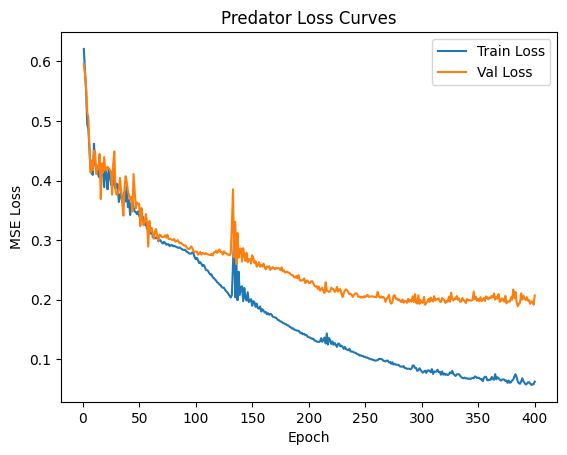

In [6]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=400, lr=1e-3, device='cpu')
torch.save(pred_policy, os.path.join(save_dir, "pred_policy.pt"))

[PREY] Epoch 01  Train Loss: 0.422891  Val Loss: 0.393534
[PREY] Epoch 02  Train Loss: 0.406926  Val Loss: 0.409266
[PREY] Epoch 03  Train Loss: 0.397182  Val Loss: 0.366161
[PREY] Epoch 04  Train Loss: 0.370486  Val Loss: 0.443567
[PREY] Epoch 05  Train Loss: 0.387953  Val Loss: 0.401012
[PREY] Epoch 06  Train Loss: 0.387796  Val Loss: 0.399931
[PREY] Epoch 07  Train Loss: 0.381721  Val Loss: 0.388978
[PREY] Epoch 08  Train Loss: 0.376765  Val Loss: 0.389455
[PREY] Epoch 09  Train Loss: 0.397744  Val Loss: 0.394106
[PREY] Epoch 10  Train Loss: 0.366847  Val Loss: 0.398409
[PREY] Epoch 11  Train Loss: 0.378401  Val Loss: 0.393693
[PREY] Epoch 12  Train Loss: 0.388383  Val Loss: 0.416514
[PREY] Epoch 13  Train Loss: 0.364960  Val Loss: 0.380298
[PREY] Epoch 14  Train Loss: 0.383083  Val Loss: 0.425601
[PREY] Epoch 15  Train Loss: 0.376435  Val Loss: 0.384788
[PREY] Epoch 16  Train Loss: 0.368193  Val Loss: 0.384361
[PREY] Epoch 17  Train Loss: 0.387356  Val Loss: 0.401067
[PREY] Epoch 1

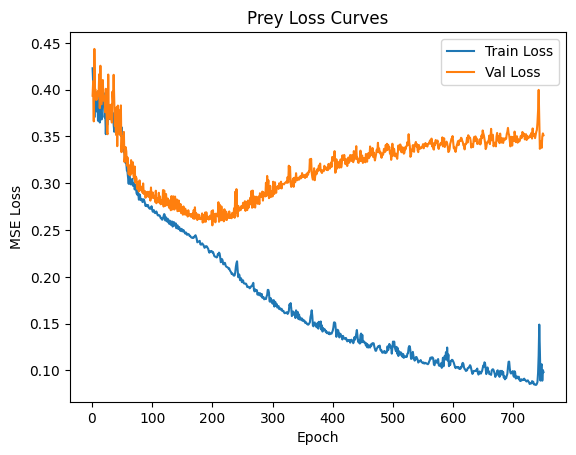

In [7]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=1024, prey_bs=2048, epochs=750, lr=1e-3, device='cpu')
torch.save(prey_policy, os.path.join(save_dir, "prey_policy.pt"))

In [8]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [16]:
env = parallel_env(predator_count=1, prey_count=30, action_count=360, use_walls=False)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy, prey_features=5)

Press 'q' to end simulation.
